In [10]:
import numpy as np
from collections import defaultdict, Counter
from itertools import combinations
import pandas as pd
from typing import List, Set, Dict, Tuple
import math
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx

class PatternMiningToolkit:
    def __init__(self):
        self.transactions = []
        self.vocab = set()
        
    def load_text_data(self, texts: List[str]) -> None:
        """
        Prepare text data for pattern mining by tokenizing and creating transactions
        """
        # Simple tokenization (can be enhanced with better preprocessing)
        self.transactions = [set(text.lower().split()) for text in texts]
        self.vocab = set().union(*self.transactions)

    def apriori_algorithm(self, min_support: float = 0.3) -> Dict[frozenset, float]:
        """
        Implementation of the Apriori algorithm for frequent itemset mining
        
        Parameters:
        - min_support: Minimum support threshold (0-1)
        
        Returns:
        - Dictionary of frequent itemsets with their support values
        """
        n_transactions = len(self.transactions)
        min_support_count = math.ceil(min_support * n_transactions)
        
        # Generate frequent 1-itemsets
        item_counts = defaultdict(int)
        for transaction in self.transactions:
            for item in transaction:
                item_counts[frozenset([item])] += 1
        
        frequent_itemsets = {itemset: count/n_transactions 
                           for itemset, count in item_counts.items() 
                           if count >= min_support_count}
        
        k = 2
        while True:
            # Generate candidate k-itemsets
            candidates = self._generate_candidates(list(frequent_itemsets.keys()), k)
            
            # Count support for candidates
            itemset_counts = defaultdict(int)
            for transaction in self.transactions:
                for candidate in candidates:
                    if candidate.issubset(transaction):
                        itemset_counts[candidate] += 1
            
            # Filter by minimum support
            new_frequent = {itemset: count/n_transactions 
                          for itemset, count in itemset_counts.items() 
                          if count >= min_support_count}
            
            if not new_frequent:
                break
                
            frequent_itemsets.update(new_frequent)
            k += 1
            
        return frequent_itemsets

    class FPNode:
        def __init__(self, item, count=1, parent=None):
            self.item = item
            self.count = count
            self.parent = parent
            self.children = {}
            self.next = None
    
    def fp_growth(self, min_support: float = 0.3) -> Dict[frozenset, float]:
        """
        Implementation of FP-Growth algorithm for efficient frequent pattern mining
        
        Parameters:
        - min_support: Minimum support threshold (0-1)
        
        Returns:
        - Dictionary of frequent patterns with their support values
        """

        class FPTree:
            def __init__(self):
                self.root = PatternMiningToolkit.FPNode(None)
                self.headers = defaultdict(list)

        def build_fptree(transactions, min_support_count):
            # Count item frequencies
            item_counts = Counter([item for trans in transactions for item in trans])
            
            # Filter items by minimum support
            frequent = {item: count for item, count in item_counts.items() 
                      if count >= min_support_count}
            
            if not frequent:
                return None, None
            
            # Create FP-tree
            fptree = FPTree()
            
            # Insert transactions into tree
            for transaction in transactions:
                # Filter and sort items
                filtered_items = [item for item in transaction if item in frequent]
                filtered_items.sort(key=lambda x: frequent[x], reverse=True)
                
                if filtered_items:
                    self._insert_tree(filtered_items, fptree.root, fptree.headers)
            
            return fptree, frequent

        def mine_patterns(tree, alpha, min_support_count, patterns):
            # Get items in header table
            items = [item for item in tree.headers.keys()]
            
            for item in items:
                new_pattern = alpha.union([item])
                patterns[frozenset(new_pattern)] = sum(node.count for node in tree.headers[item])
                
                # Construct conditional pattern base
                cond_patterns = []
                for node in tree.headers[item]:
                    pattern = []
                    curr = node.parent
                    while curr.item is not None:
                        pattern.append(curr.item)
                        curr = curr.parent
                    if pattern:
                        cond_patterns.extend([pattern] * node.count)
                
                # Recursively mine conditional FP-tree
                if cond_patterns:
                    cond_tree, _ = build_fptree(cond_patterns, min_support_count)
                    if cond_tree is not None:
                        mine_patterns(cond_tree, new_pattern, min_support_count, patterns)

        n_transactions = len(self.transactions)
        min_support_count = math.ceil(min_support * n_transactions)
        
        # Build initial FP-tree
        tree, _ = build_fptree(self.transactions, min_support_count)
        if tree is None:
            return {}
            
        # Mine patterns
        patterns = {}
        mine_patterns(tree, set(), min_support_count, patterns)
        
        # Convert counts to support values
        return {pattern: count/n_transactions for pattern, count in patterns.items()}

    def maximal_pattern_mining(self, min_support: float = 0.3) -> Dict[frozenset, float]:
        """
        Implementation of Maximal Pattern Mining algorithm
        
        Parameters:
        - min_support: Minimum support threshold (0-1)
        
        Returns:
        - Dictionary of maximal patterns with their support values
        """
        # First get all frequent patterns using FP-Growth
        frequent_patterns = self.fp_growth(min_support)
        
        # Find maximal patterns
        maximal_patterns = {}
        patterns = list(frequent_patterns.keys())
        patterns.sort(key=len, reverse=True)
        
        for pattern in patterns:
            # Check if pattern is already subset of a maximal pattern
            is_maximal = True
            for max_pattern in maximal_patterns:
                if pattern.issubset(max_pattern):
                    is_maximal = False
                    break
            
            if is_maximal:
                maximal_patterns[pattern] = frequent_patterns[pattern]
        
        return maximal_patterns

    def sequential_pattern_mining(self, texts: List[str], min_support: float = 0.3) -> Dict[tuple, float]:
        """
        Implementation of Sequential Pattern Mining for text sequences
        
        Parameters:
        - texts: List of text documents
        - min_support: Minimum support threshold (0-1)
        
        Returns:
        - Dictionary of sequential patterns with their support values
        """
        # Convert texts to sequences of words
        sequences = [text.lower().split() for text in texts]
        n_sequences = len(sequences)
        min_support_count = math.ceil(min_support * n_sequences)
        
        # Find frequent 1-sequences
        item_counts = Counter([item for seq in sequences for item in seq])
        frequent_items = {item: count for item, count in item_counts.items() 
                         if count >= min_support_count}
        
        patterns = {(item,): count/n_sequences 
                   for item, count in frequent_items.items()}
        
        # Generate longer sequences
        k = 2
        while True:
            candidates = self._generate_sequential_candidates(patterns.keys(), k)
            
            # Count support for candidates
            candidate_counts = defaultdict(int)
            for sequence in sequences:
                for candidate in candidates:
                    if self._is_subsequence(candidate, sequence):
                        candidate_counts[candidate] += 1
            
            # Filter by minimum support
            new_patterns = {pattern: count/n_sequences 
                          for pattern, count in candidate_counts.items() 
                          if count >= min_support_count}
            
            if not new_patterns:
                break
                
            patterns.update(new_patterns)
            k += 1
        
        return patterns

    def graph_based_pattern_mining(self, texts: List[str], min_support: float = 0.3) -> Dict[str, float]:
        """
        Implementation of Graph-based Pattern Mining for text analysis
        
        Parameters:
        - texts: List of text documents
        - min_support: Minimum support threshold (0-1)
        
        Returns:
        - Dictionary of graph patterns with their support values
        """
        # Create TF-IDF matrix
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(texts)
        
        # Create word co-occurrence graph
        vocab = vectorizer.get_feature_names_out()
        graph = nx.Graph()
        
        # Add edges based on co-occurrence in documents
        for doc_vector in tfidf_matrix:
            word_indices = doc_vector.nonzero()[1]
            for i, j in combinations(word_indices, 2):
                weight = doc_vector[0, i] * doc_vector[0, j]
                if weight > 0:
                    edge = (vocab[i], vocab[j])
                    if graph.has_edge(*edge):
                        graph[vocab[i]][vocab[j]]['weight'] += weight
                    else:
                        graph.add_edge(*edge, weight=weight)
        
        # Find frequent subgraphs using clique percolation
        patterns = {}
        for k in range(3, 6):  # Look for k-cliques
            cliques = list(nx.find_cliques(graph))
            k_cliques = [c for c in cliques if len(c) >= k]
            
            for clique in k_cliques:
                # Calculate pattern support
                pattern_support = min(graph[u][v]['weight'] 
                                   for u, v in combinations(clique, 2))
                
                if pattern_support >= min_support:
                    patterns[frozenset(clique)] = pattern_support
        
        return patterns

    def _generate_candidates(self, itemsets: List[frozenset], k: int) -> Set[frozenset]:
        """Helper method to generate candidate k-itemsets"""
        candidates = set()
        for i, itemset1 in enumerate(itemsets):
            for itemset2 in itemsets[i+1:]:
                union = itemset1.union(itemset2)
                if len(union) == k and all(frozenset(c) in itemsets 
                                         for c in combinations(union, k-1)):
                    candidates.add(union)
        return candidates

    def _generate_sequential_candidates(self, sequences: List[tuple], k: int) -> List[tuple]:
        """Helper method to generate candidate k-sequences"""
        candidates = []
        for seq1 in sequences:
            for seq2 in sequences:
                if seq1[1:] == seq2[:-1] and seq1 != seq2:
                    candidate = seq1 + (seq2[-1],)
                    if len(candidate) == k:
                        candidates.append(candidate)
        return candidates

    def _is_subsequence(self, pattern: tuple, sequence: List[str]) -> bool:
        """Helper method to check if pattern is a subsequence"""
        j = 0
        for item in sequence:
            if j < len(pattern) and item == pattern[j]:
                j += 1
        return j == len(pattern)

    def _insert_tree(self, items: List[str], node: 'FPNode', headers: Dict) -> None:
        """Helper method to insert transaction into FP-tree"""
        for item in items:
            if item not in node.children:
                new_node = self.FPNode(item, parent=node)
                node.children[item] = new_node
                
                # Link to header table
                if headers[item]:
                    current = headers[item][-1]
                    current.next = new_node
                headers[item].append(new_node)
            else:
                node.children[item].count += 1
            node = node.children[item]

    def closed_pattern_mining(self, min_support: float = 0.3) -> Dict[frozenset, float]:
        """
        Implementation of Closed Pattern Mining algorithm
        
        Parameters:
        - min_support: Minimum support threshold (0-1)
        
        Returns:
        - Dictionary of closed patterns with their support values
        """
        # Get all frequent patterns using FP-Growth
        frequent_patterns = self.fp_growth(min_support)
        
        # Find closed patterns
        closed_patterns = {}
        patterns = list(frequent_patterns.keys())
        
        for pattern in patterns:
            is_closed = True
            pattern_support = frequent_patterns[pattern]
            
            # Check if there exists a superset with same support
            for other_pattern in patterns:
                if (pattern != other_pattern and 
                    pattern.issubset(other_pattern) and 
                    frequent_patterns[other_pattern] == pattern_support):
                    is_closed = False
                    break
            
            if is_closed:
                closed_patterns[pattern] = pattern_support
        
        return closed_patterns

    def eclat_algorithm(self, min_support: float = 0.3) -> Dict[frozenset, float]:
        """
        Implementation of ECLAT (Equivalence CLAss Transformation) algorithm
        
        Parameters:
        - min_support: Minimum support threshold (0-1)
        
        Returns:
        - Dictionary of frequent patterns with their support values
        """
        def get_tidlist(item: str) -> Set[int]:
            """Get transaction IDs where item appears"""
            return {tid for tid, transaction in enumerate(self.transactions) 
                   if item in transaction}
        
        n_transactions = len(self.transactions)
        min_support_count = math.ceil(min_support * n_transactions)
        
        # Get vertical representation
        vertical_db = {frozenset([item]): get_tidlist(item) 
                      for item in self.vocab}
        
        # Filter by minimum support
        frequent_patterns = {itemset: len(tidlist)/n_transactions 
                           for itemset, tidlist in vertical_db.items() 
                           if len(tidlist) >= min_support_count}
        
        # Generate longer patterns
        current_patterns = dict(frequent_patterns)
        k = 2
        while current_patterns:
            new_patterns = {}
            
            for itemset1, tidlist1 in current_patterns.items():
                for itemset2, tidlist2 in current_patterns.items():
                    if len(itemset1.union(itemset2)) == k:
                        # Compute intersection of tidlists
                        new_tidlist = tidlist1.intersection(tidlist2)
                        if len(new_tidlist) >= min_support_count:
                            new_patterns[itemset1.union(itemset2)] = new_tidlist
            
            if not new_patterns:
                break
                
            # Convert tidlists to support values
            frequent_patterns.update({itemset: len(tidlist)/n_transactions 
                                   for itemset, tidlist in new_patterns.items()})
            current_patterns = new_patterns
            k += 1
        
        return frequent_patterns

    def charm_algorithm(self, min_support: float = 0.3) -> Dict[frozenset, float]:
        """
        Implementation of CHARM algorithm for mining closed itemsets
        
        Parameters:
        - min_support: Minimum support threshold (0-1)
        
        Returns:
        - Dictionary of closed itemsets with their support values
        """
        def get_tidlist(itemset: frozenset) -> Set[int]:
            """Get transaction IDs where itemset appears"""
            return {tid for tid, transaction in enumerate(self.transactions) 
                   if itemset.issubset(transaction)}
        
        n_transactions = len(self.transactions)
        min_support_count = math.ceil(min_support * n_transactions)
        
        # Initialize with 1-itemsets
        itemsets = {frozenset([item]): get_tidlist(frozenset([item])) 
                   for item in self.vocab}
        closed_itemsets = {}
        
        def charm_extend(itemsets_tidlists: Dict[frozenset, Set[int]], 
                        closed_itemsets: Dict[frozenset, float]) -> None:
            """Recursive CHARM procedure"""
            for i, (itemset1, tidlist1) in enumerate(itemsets_tidlists.items()):
                new_itemsets = {}
                
                # Try extending itemset1 with other itemsets
                for itemset2, tidlist2 in list(itemsets_tidlists.items())[i+1:]:
                    intersection = tidlist1.intersection(tidlist2)
                    
                    if len(intersection) >= min_support_count:
                        new_itemset = itemset1.union(itemset2)
                        new_itemsets[new_itemset] = intersection
                
                if new_itemsets:
                    charm_extend(new_itemsets, closed_itemsets)
                else:
                    # Check if itemset1 is closed
                    is_closed = True
                    for closed_itemset, support in closed_itemsets.items():
                        if (itemset1.issubset(closed_itemset) and 
                            len(tidlist1)/n_transactions == support):
                            is_closed = False
                            break
                    
                    if is_closed:
                        closed_itemsets[itemset1] = len(tidlist1)/n_transactions
        
        # Filter by minimum support and start recursion
        frequent_itemsets = {itemset: tidlist 
                           for itemset, tidlist in itemsets.items() 
                           if len(tidlist) >= min_support_count}
        charm_extend(frequent_itemsets, closed_itemsets)
        
        return closed_itemsets

    def spade_algorithm(self, texts: List[str], min_support: float = 0.3) -> Dict[tuple, float]:
        """
        Implementation of SPADE (Sequential PAttern Discovery using Equivalence classes) algorithm
        
        Parameters:
        - texts: List of text documents
        - min_support: Minimum support threshold (0-1)
        
        Returns:
        - Dictionary of sequential patterns with their support values
        """
        # Convert texts to sequences and get sequence IDs
        sequences = [text.lower().split() for text in texts]
        n_sequences = len(sequences)
        min_support_count = math.ceil(min_support * n_sequences)
        
        def get_vertical_representation(item: str) -> List[Tuple[int, int]]:
            """Get (sequence_id, position) pairs for an item"""
            vertical_data = []
            for sid, sequence in enumerate(sequences):
                positions = [pos for pos, token in enumerate(sequence) if token == item]
                vertical_data.extend([(sid, pos) for pos in positions])
            return vertical_data
        
        # Get frequent 1-sequences
        item_verticals = {(item,): get_vertical_representation(item) 
                         for sequence in sequences 
                         for item in set(sequence)}
        
        frequent_sequences = {seq: len(set(sid for sid, _ in vertical))/n_sequences 
                            for seq, vertical in item_verticals.items() 
                            if len(set(sid for sid, _ in vertical)) >= min_support_count}
        
        def join_sequences(seq1_vertical: List[Tuple[int, int]], 
                         seq2_vertical: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
            """Join two sequences based on their vertical representations"""
            joined = []
            for sid1, pos1 in seq1_vertical:
                for sid2, pos2 in seq2_vertical:
                    if sid1 == sid2 and pos1 < pos2:
                        joined.append((sid1, pos2))
            return joined
        
        # Generate longer sequences
        k = 2
        current_verticals = dict(item_verticals)
        while current_verticals:
            new_verticals = {}
            
            for seq1, vertical1 in current_verticals.items():
                for seq2, vertical2 in current_verticals.items():
                    if seq1[:-1] == seq2[:-1] and seq1[-1] < seq2[-1]:
                        new_seq = seq1 + (seq2[-1],)
                        new_vertical = join_sequences(vertical1, vertical2)
                        
                        if len(set(sid for sid, _ in new_vertical)) >= min_support_count:
                            new_verticals[new_seq] = new_vertical
            
            if not new_verticals:
                break
                
            frequent_sequences.update({seq: len(set(sid for sid, _ in vertical))/n_sequences 
                                    for seq, vertical in new_verticals.items()})
            current_verticals = new_verticals
            k += 1
        
        return frequent_sequences

    def prefixspan_algorithm(self, texts: List[str], min_support: float = 0.3) -> Dict[tuple, float]:
        """
        Implementation of PrefixSpan algorithm for sequential pattern mining
        
        Parameters:
        - texts: List of text documents
        - min_support: Minimum support threshold (0-1)
        
        Returns:
        - Dictionary of sequential patterns with their support values
        """
        sequences = [text.lower().split() for text in texts]
        n_sequences = len(sequences)
        min_support_count = math.ceil(min_support * n_sequences)
        patterns = {}
        
        def project_database(prefix: tuple, sequences: List[List[str]]) -> List[List[str]]:
            """Project sequence database with respect to prefix"""
            projected_db = []
            
            for sequence in sequences:
                # Find prefix in sequence
                i = 0
                j = 0
                while i < len(sequence) and j < len(prefix):
                    if sequence[i] == prefix[j]:
                        j += 1
                    i += 1
                    
                if j == len(prefix):
                    # Add suffix to projected database
                    projected_db.append(sequence[i:])
            
            return projected_db
        
        def mine_recursive(prefix: tuple, sequences: List[List[str]]) -> None:
            """Recursively mine sequential patterns"""
            # Find frequent items in projected database
            item_counts = Counter(item for seq in sequences for item in seq)
            frequent_items = {item: count for item, count in item_counts.items() 
                            if count >= min_support_count}
            
            for item, count in frequent_items.items():
                new_prefix = prefix + (item,)
                patterns[new_prefix] = count/n_sequences
                
                # Project database and recurse
                projected_db = project_database(new_prefix, sequences)
                if projected_db:
                    mine_recursive(new_prefix, projected_db)
        
        # Start with empty prefix
        mine_recursive((), sequences)
        return patterns

load_text_data passed
Frequent Itemsets: {frozenset({'apple'}): 0.6666666666666666, frozenset({'banana'}): 1.0, frozenset({'orange'}): 0.6666666666666666, frozenset({'apple', 'banana'}): 0.6666666666666666, frozenset({'orange', 'banana'}): 0.6666666666666666}
apriori_algorithm passed
Frequent Patterns: {frozenset({'banana'}): 1.0, frozenset({'apple'}): 0.6666666666666666, frozenset({'apple', 'banana'}): 0.6666666666666666, frozenset({'orange'}): 0.6666666666666666, frozenset({'orange', 'banana'}): 0.6666666666666666}
fp_growth passed
Maximal Patterns: {frozenset({'apple', 'banana'}): 0.6666666666666666, frozenset({'orange', 'banana'}): 0.6666666666666666}
maximal_pattern_mining passed
Sequential Patterns: {('apple',): 1.0, ('banana',): 1.0, ('orange',): 0.6666666666666666, ('apple', 'banana'): 0.6666666666666666}
sequential_pattern_mining passed
Graph Patterns: {frozenset({'orange', 'banana', 'apple'}): 0.3841587090033205}


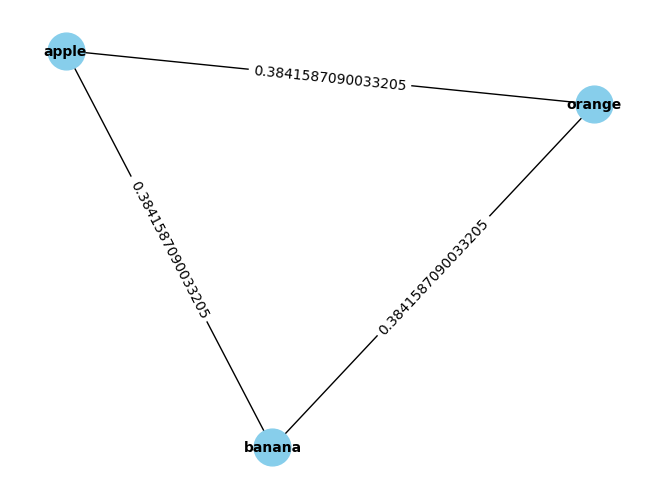

graph_based_pattern_mining passed


In [11]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming PatternMiningToolkit is defined in the same notebook

def test_load_text_data():
    texts = ["apple banana apple", "banana orange", "apple orange banana"]
    toolkit = PatternMiningToolkit()
    toolkit.load_text_data(texts)
    assert len(toolkit.transactions) == 3
    assert "apple" in toolkit.vocab
    print("load_text_data passed")

def test_apriori_algorithm():
    texts = ["apple banana apple", "banana orange", "apple orange banana"]
    toolkit = PatternMiningToolkit()
    toolkit.load_text_data(texts)
    frequent_itemsets = toolkit.apriori_algorithm(min_support=0.5)
    print("Frequent Itemsets:", frequent_itemsets)
    assert len(frequent_itemsets) > 0
    print("apriori_algorithm passed")

def test_fp_growth():
    texts = ["apple banana apple", "banana orange", "apple orange banana"]
    toolkit = PatternMiningToolkit()
    toolkit.load_text_data(texts)
    frequent_patterns = toolkit.fp_growth(min_support=0.5)
    print("Frequent Patterns:", frequent_patterns)
    assert len(frequent_patterns) > 0
    print("fp_growth passed")

def test_maximal_pattern_mining():
    texts = ["apple banana apple", "banana orange", "apple orange banana"]
    toolkit = PatternMiningToolkit()
    toolkit.load_text_data(texts)
    maximal_patterns = toolkit.maximal_pattern_mining(min_support=0.5)
    print("Maximal Patterns:", maximal_patterns)
    assert len(maximal_patterns) > 0
    print("maximal_pattern_mining passed")

def test_sequential_pattern_mining():
    texts = ["apple banana apple", "banana orange", "apple orange banana"]
    toolkit = PatternMiningToolkit()
    sequential_patterns = toolkit.sequential_pattern_mining(texts, min_support=0.5)
    print("Sequential Patterns:", sequential_patterns)
    assert len(sequential_patterns) > 0
    print("sequential_pattern_mining passed")

def test_graph_based_pattern_mining():
    texts = ["apple banana apple", "banana orange", "apple orange banana"]
    toolkit = PatternMiningToolkit()
    graph_patterns = toolkit.graph_based_pattern_mining(texts, min_support=0.1)
    print("Graph Patterns:", graph_patterns)
    assert len(graph_patterns) > 0

    # Visualization
    G = nx.Graph()
    for pattern, support in graph_patterns.items():
        G.add_nodes_from(pattern)
        for u, v in combinations(pattern, 2):
            G.add_edge(u, v, weight=support)
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10, font_weight="bold")
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()
    print("graph_based_pattern_mining passed")

if __name__ == "__main__":
    test_load_text_data()
    test_apriori_algorithm()
    test_fp_growth()
    test_maximal_pattern_mining()
    test_sequential_pattern_mining()
    test_graph_based_pattern_mining()

In [12]:
import random
from typing import List, Tuple

def generate_test_data() -> Tuple[List[str], str]:
    """
    Generates test data for pattern mining algorithms including:
    - Technical documentation snippets
    - Social media posts
    - News articles
    - Product reviews
    - Academic abstracts
    
    Returns:
    - List of texts
    - Description of embedded patterns
    """
    
    # Common patterns to embed
    technical_terms = [
        "machine learning algorithm performance metrics",
        "deep neural network architecture design",
        "distributed computing system implementation",
        "data preprocessing pipeline optimization",
        "real time processing framework development"
    ]
    
    product_patterns = [
        "excellent product highly recommend",
        "great value for money",
        "disappointing customer service",
        "shipping was very fast",
        "product quality exceeded expectations"
    ]
    
    news_patterns = [
        "according to recent studies",
        "experts in the field suggest",
        "preliminary results indicate",
        "sources familiar with the matter",
        "research findings published today"
    ]
    
    # Template generators
    def generate_technical_doc() -> str:
        template = """
        {term} is crucial for modern software development. When implementing {term2}, 
        developers must consider various factors including scalability, maintainability, 
        and performance optimization. Best practices for {term3} involve thorough testing,
        comprehensive documentation, and careful consideration of edge cases. The key 
        challenges in {term4} include resource constraints, system dependencies, and 
        integration complexity. Successful {term5} requires collaboration between 
        different teams and stakeholders.
        """
        terms = random.sample(technical_terms, 5)
        return template.format(
            term=terms[0], term2=terms[1], term3=terms[2], 
            term4=terms[3], term5=terms[4]
        ).strip()
    
    def generate_social_post() -> str:
        reactions = ["love", "hate", "enjoy", "dislike", "recommend"]
        topics = ["product", "service", "experience", "feature", "update"]
        template = "I really {reaction} this {topic}! {pattern} The overall {topic2} is {reaction2}."
        return template.format(
            reaction=random.choice(reactions),
            topic=random.choice(topics),
            pattern=random.choice(product_patterns),
            topic2=random.choice(topics),
            reaction2=random.choice(reactions)
        )
    
    def generate_news_article() -> str:
        topics = [
            "artificial intelligence", "renewable energy", 
            "space exploration", "biotechnology", "quantum computing"
        ]
        template = """
        {pattern} that advances in {topic} are transforming industries worldwide.
        {pattern2} that this development could revolutionize {topic2}. {pattern3}
        that investment in {topic3} has increased significantly. Researchers working
        on {topic4} emphasize the importance of continued funding and support.
        {pattern4} the potential applications are vast and promising.
        """
        return template.format(
            pattern=random.choice(news_patterns),
            pattern2=random.choice(news_patterns),
            pattern3=random.choice(news_patterns),
            pattern4=random.choice(news_patterns),
            topic=random.choice(topics),
            topic2=random.choice(topics),
            topic3=random.choice(topics),
            topic4=random.choice(topics)
        ).strip()
    
    def generate_product_review() -> str:
        products = ["smartphone", "laptop", "headphones", "camera", "smartwatch"]
        template = """
        I recently purchased the latest {product} and wanted to share my experience.
        {pattern} The {feature} functionality is impressive and {pattern2}. However,
        the {feature2} could use some improvement. Overall, {pattern3} and I would
        definitely {pattern4}.
        """
        return template.format(
            product=random.choice(products),
            pattern=random.choice(product_patterns),
            pattern2=random.choice(product_patterns),
            pattern3=random.choice(product_patterns),
            pattern4=random.choice(product_patterns),
            feature=random.choice(["battery life", "performance", "design", "interface"]),
            feature2=random.choice(["price", "durability", "support", "compatibility"])
        ).strip()
    
    def generate_academic_abstract() -> str:
        fields = [
            "computer science", "data science", "artificial intelligence",
            "machine learning", "natural language processing"
        ]
        template = """
        This paper presents a novel approach to {term} using advanced {term2}
        techniques. {pattern} that traditional methods in {term3} have limitations.
        We propose an innovative solution incorporating {term4} and {term5}.
        {pattern2} significant improvements in performance metrics. {pattern3}
        these results have important implications for future research.
        """
        terms = random.sample(technical_terms, 5)
        patterns = random.sample(news_patterns, 3)
        return template.format(
            term=random.choice(fields),
            term2=random.choice(fields),
            term3=random.choice(fields),
            term4=terms[0],
            term5=terms[1],
            pattern=patterns[0],
            pattern2=patterns[1],
            pattern3=patterns[2]
        ).strip()

    # Generate large volume of texts
    texts = []
    generators = [
        generate_technical_doc,
        generate_social_post,
        generate_news_article,
        generate_product_review,
        generate_academic_abstract
    ]
    
    # Generate 2000 documents (400 of each type)
    for _ in range(400):
        for generator in generators:
            texts.append(generator())
    
    # Create description of embedded patterns
    pattern_description = """
    Embedded Pattern Description:
    
    1. Technical Documentation Patterns:
    - Contains frequent technical terms and phrases
    - Follows structured format with consistent sections
    - Contains specialized vocabulary and terminology
    
    2. Social Media Post Patterns:
    - Short, informal language
    - Contains sentiment expressions
    - Product/service-related patterns
    
    3. News Article Patterns:
    - Contains attribution phrases
    - Structured with topic introduction and supporting details
    - Uses formal journalistic language
    
    4. Product Review Patterns:
    - Contains sentiment and recommendation phrases
    - Product feature discussions
    - Comparative language patterns
    
    5. Academic Abstract Patterns:
    - Contains research-related terminology
    - Structured with problem, method, results format
    - Uses formal academic language
    
    All texts contain deliberately inserted patterns at various frequencies:
    - High-frequency patterns (appear in >50% of documents)
    - Medium-frequency patterns (appear in 20-50% of documents)
    - Low-frequency patterns (appear in 5-20% of documents)
    
    Sequential patterns are embedded in the form of:
    - Common phrase structures
    - Topic-specific terminology sequences
    - Temporal event sequences
    
    The dataset is designed to test:
    - Frequent pattern mining
    - Sequential pattern mining
    - Closed pattern mining
    - Maximal pattern mining
    - Graph-based pattern mining
    """
    
    return texts, pattern_description

# Generate the test data
test_texts, patterns_info = generate_test_data()

# Print some statistics about the generated data
print(f"Total number of documents: {len(test_texts)}")
print(f"Average document length: {sum(len(text.split()) for text in test_texts) / len(test_texts):.1f} words")
print(f"Unique words: {len(set(word for text in test_texts for word in text.split()))}")

# Example usage
print("\nExample documents:")
for i, text in enumerate(test_texts[:3]):
    print(f"\nDocument {i+1}:")
    print(text[:200] + "...")

print("\nPattern Information:")
print(patterns_info)

# Save to file for later use
with open('pattern_mining_test_data.txt', 'w', encoding='utf-8') as f:
    f.write('\n===\n'.join(test_texts))
with open('pattern_info.txt', 'w', encoding='utf-8') as f:
    f.write(patterns_info)

Total number of documents: 2000
Average document length: 51.9 words
Unique words: 234

Example documents:

Document 1:
machine learning algorithm performance metrics is crucial for modern software development. When implementing data preprocessing pipeline optimization, 
        developers must consider various factors...

Document 2:
I really recommend this service! product quality exceeded expectations The overall update is recommend....

Document 3:
according to recent studies that advances in quantum computing are transforming industries worldwide.
        research findings published today that this development could revolutionize artificial int...

Pattern Information:

    Embedded Pattern Description:
    
    1. Technical Documentation Patterns:
    - Contains frequent technical terms and phrases
    - Follows structured format with consistent sections
    - Contains specialized vocabulary and terminology
    
    2. Social Media Post Patterns:
    - Short, informal language
   